In [7]:
!pip install imbalanced-learn==0.9.0

     |████████████████████████████████| 204kB 10.2MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
n_subj = 8
n_sessions = 37 # max. session number (some subjects have fewer sessions)
n_rois = 10 # in MTL
n_trials = 750 # in one session

In [25]:
## classification

acc = np.empty((n_subj,n_rois,n_sessions))
acc[:] = np.NaN
y_actual = np.empty((n_subj,n_rois,n_sessions,n_trials))
y_actual[:] = np.NaN
y_predicted = np.empty((n_subj,n_rois,n_sessions,n_trials))
y_predicted[:] = np.NaN
sessions_per_subject = list()

#clf = OneVsRestClassifier((SVC(kernel='linear')))
clf = LinearDiscriminantAnalysis()
#clf = RandomForestClassifier(max_depth=2, random_state=0)


for isubj in range(n_subj):
    print(isubj)
    
    # get behavioural data
    subj_behav_file = "subj0%s/nsd_s%s_sigDetect" %(isubj+1,isubj+1)
    subj_behav = pd.read_csv(subj_behav_file, delimiter="\t")
    

    for iroi in range(n_rois):
        #print('ROI: ' + str(iroi))
        
        # get fMRI data for this ROI
        X = np.load("subj0%s/MTL-S%s-%s_full.npy" %(isubj+1,isubj+1,iroi+1))
        
        # get number of sessions for this subject (as they differ per subject)
        curr_num_sessions = int(X.shape[0]/n_trials)
        sessions_per_subject.append(curr_num_sessions)
        
        # for behavioural data, drop those sessions for which fMRI data is not available
        subj_behav = subj_behav[~subj_behav["SESSION"].isin(np.arange(0,40-curr_num_sessions)+curr_num_sessions+1)]
        
        # get labels
        # 0: HIT; # 1: MISS; # 2: CORRECT REJECTION; # 3: FALSE ALARM; # 4: NO RESPONSE
        labels = subj_behav["SigDetection"]
        labels = labels.to_numpy(labels)
        
        # get session number
        sessions = subj_behav["SESSION"]
        sessions = sessions.to_numpy(sessions)
    
        # delete trials where subject didn't respond and so we don't have a label (==4)
        # also get rid of some of the conditions
        #X = np.delete(X,np.where((labels==4) | (labels==1) | (labels==3)),0)
        X = np.delete(X,np.where(labels==4),0)
        #sessions = np.delete(sessions,np.where((labels==4) | (labels==1) | (labels==3)),0)
        sessions = np.delete(sessions,np.where(labels==4),0)
        #y = np.delete(labels,np.where((labels==4) | (labels==1) | (labels==3)),0)
        y = np.delete(labels,np.where(labels==4),0)
        #y[y==0] = 3
        #y[y==1] = 2
                
        #print(X.shape)
        
        
        # every session gets left out once as testing data
        for isession in range(curr_num_sessions):
            #print(isession)
            
            X_train = np.delete(X,np.where(sessions==isession+1),0)
            y_train = np.delete(y,np.where(sessions==isession+1),0)
            
            # make the training data balanced
            rus = RandomUnderSampler(random_state=42,sampling_strategy='not minority')
            #rus = RandomOverSampler(random_state=42,sampling_strategy='not majority')
            #sm = SMOTE(random_state=42,sampling_strategy='not majority')
            X_train, y_train = rus.fit_resample(X_train, y_train)

            X_test = np.delete(X,np.where(sessions!=isession+1),0)
            y_test = np.delete(y,np.where(sessions!=isession+1),0)
            
            # run PCA
            #0 < n_components < 1 and svd_solver == 'full', 
            #pca = PCA(n_components=int(np.round(X_train.shape[1]/4)))
            #pca = PCA(n_components=0.25)
            #pca.fit(X_train)
            #X_train = pca.transform(X_train)
            #X_test = pca.transform(X_test)
            

            clf.fit(X_train,y_train)
            
            y_predict = clf.predict(X_test)
            acc[isubj,iroi,isession] = np.mean(y_predict == y_test)
            
            y_actual[isubj,iroi,isession,0:len(y_test)] = y_test
            y_predicted[isubj,iroi,isession,0:len(y_test)] = y_predict

0
1
2
3
4
5
6
7


In [26]:
np.save("results/acc_4way",acc)
np.save("results/y_actual_4way",y_actual)
np.save("results/y_predicted_4way",y_predicted)

In [27]:
#print(acc)
print(np.mean(np.nanmean(acc,axis=2),axis=0))

[0.28410606 0.29550251 0.28383552 0.28508417 0.28396436 0.26561239
 0.28600046 0.28289784 0.30390004 0.2764908 ]


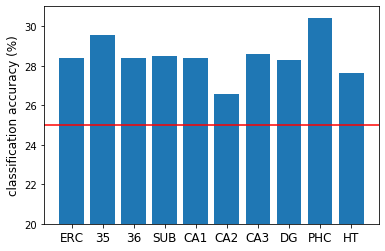

In [32]:
# plot classification accuracy for the 10 ROIs

fig,axs = plt.subplots()
axs.bar(np.linspace(1,10,10),np.mean(np.nanmean(acc,axis=2),axis=0)*100)
axs.set_ylabel('classification accuracy (%)',fontsize=12)
axs.set_xticks(np.linspace(1,10,10))
axs.set_xticklabels(['ERC','35','36','SUB','CA1','CA2','CA3','DG','PHC','HT'],fontsize=12)
axs.set_ylim([20,31])
plt.axhline(y = 25, color = 'r', linestyle = '-')

# error bars and individual data points

In [36]:
confMatrices = np.zeros((n_subj,n_rois,4,4))

for isubj in range(n_subj):
    for iroi in range(n_rois):
        
        y_true = np.concatenate(y_actual[isubj,iroi])
        y_pred = np.concatenate(y_predicted[isubj,iroi])
        
        # remove NaN (there because some trials don't have response)
        y_true = y_true[np.logical_not(np.isnan(y_true))]
        y_pred = y_pred[np.logical_not(np.isnan(y_pred))]
        
        confMatrix = confusion_matrix(y_true,y_pred)
        # convert to percentages
        divideby = np.sum(confMatrix,axis=1)
        divideby = np.transpose(np.repeat([divideby], 4, axis=0))
        confMatrix_percentage = np.divide(confMatrix,divideby)
        
        confMatrices[isubj,iroi] = confMatrix_percentage*100

In [37]:
np.save("results/confMatrices_4way",confMatrices)